In [1]:
import clip
from fastai.vision.all import *

import pandas as pd

import glob
import newlinejson

from helper import *

In [2]:
def new_resnet(pretrained):
    '''
    fix for cnn_learner module using non-standard pre-trained models
    '''
    return default_res50

def make_prediction(path, topk=5):
    output_ = {}
    label, y, output = learner.predict(path)
    probs, preds = output.topk(5)
    for index, class_ in enumerate(preds):
        output_[classes[class_]] = round(float(probs[index]),4)
    return output_



def make_avg_prediction(data, path, topk=5):
    output_ = {}
    
    # make places predictions
    label, y, output = learner.predict(path)
    output_places = output.numpy()
    output_places = np.expand_dims(output_places, axis=0)

    
    # make clip predictions
    img_features = get_single_img_features(path)
    output_clip = CLIP_model.predict_proba(img_features)
    
    # soft averaging
    avg = np.average([output_places, output_clip], axis=0)
    
    # select top-k
    topk = topk * -1
    
    best_n = np.argsort(avg, axis=1)[:,topk:]
    probabilities = np.round(np.sort(avg, axis=1)[:,topk:], 2)
    labels = [data.vocab[i] for i in best_n]
    
    for i, _ in enumerate(probabilities[0]):
        output_[labels[0][i]] = probabilities[0][i]
    return output_

In [3]:
# setting path variables 
Path.BASE_PATH = Path('../../MelvinWevers#9512/DeBoer_Train')
Path.BASE_PATH.ls()
path = Path.BASE_PATH

In [4]:
data = get_dls(128, 224, path, augment=False)
classes = data.vocab

/opt/conda/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [5]:
classes

['akker', 'amfitheater', 'aula', 'auto', 'auto_ongeluk', 'bakkerij', 'basketbal_korfbal', 'begraafplaats', 'begrafenis', 'bibliotheek_boekwinkel', 'binnen_zwembad', 'bloemen', 'bloementuin', 'boksen', 'borden_gevelsteen', 'bos_park', 'boten', 'bouwplaats', 'brand', 'brug', 'bruiloft', 'buiten_zwembad', 'bus_truck', 'cafe', 'catwalk', 'circus', 'cricket', 'dansende_mensen', 'demonstratie', 'dieren_overig', 'duinen', 'eend', 'etalage', 'etende_mensen', 'fabriek', 'fietsende_mensen', 'garage_showroom', 'gebouw', 'geestelijken', 'groepsportret', 'gymnastiek', 'handbal', 'hardlopen', 'haven', 'herdenking', 'historisch_toneelstuk', 'hockey', 'hond', 'honkbal', 'huisje', 'kaartspel', 'kade', 'kamperen', 'kantoor', 'kapper', 'kerk_binnen', 'kerk_buiten', 'kermis', 'kerstmis', 'keuken', 'klaslokaal', 'koe', 'konijn', 'kunstwerk', 'luchtfoto', 'maquette', 'markt', 'mensen_op_een_boot', 'mensen_op_trap', 'mensenmassa', 'militair', 'motorfiets', 'muziek_optreden', 'ongeluk_brancard', 'ontvangst_af

In [6]:
test_img = '../../MelvinWevers#9512/DeBoer_Train/basketbal_korfbal/NL-HlmNHA_1478_09288_G.jpg'

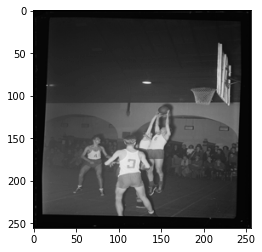

In [7]:
img = Image.open(test_img)
img = img.resize((256, 256))

plt.imshow(img, cmap='gray')

## Make predictions with Fine-Tuned Places-365 Model

In [30]:
learner = load_learner('./models/DeBoer_places.pkl')

In [118]:
label, y, output = learner.predict(test_img)

In [14]:
probs, preds = output.topk(5)
output_ = {}

top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)

In [15]:
for index, class_ in enumerate(preds):
    output_[classes[class_]] = round(float(probs[index]),4)

In [16]:
output_

{'basketbal_korfbal': 0.9368,
 'hardlopen': 0.0134,
 'zeepkistenrace': 0.0049,
 'auto': 0.0033,
 'voetbal': 0.0032}

## Make Prediction with CLIP-Linear Probe

In [17]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 31.8MiB/s]


In [18]:
def get_single_img_features(img_path):
    '''
    extract features from a single image using CLIP
    '''
        
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
  
    with torch.no_grad():
        features = model.encode_image(image)

    return features.cpu().numpy()

In [19]:
# load the model from disk
filename = './models/linear_probe_model.sav'
model_path = './models/'
CLIP_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
# print(result)

In [20]:
img_features = get_single_img_features(test_img)

In [21]:
predictions = CLIP_model.predict(img_features)

In [22]:
probs_ = CLIP_model.predict_proba(img_features)
best_n = np.argsort(probs_, axis=1)[:,-5:]
probabilities = np.round(np.sort(probs_, axis=1)[:,-5:], 4)
#test_labels[i] in best_n[i]:

In [23]:
labels = [data.vocab[i] for i in best_n]

In [24]:
output_ = {}
for i, _ in enumerate(probabilities[0]):
    output_[labels[0][i]] = probabilities[0][i]
output_

{'handbal': 0.0016,
 'zaalvoetbal': 0.0021,
 'volleybal': 0.004,
 'gymnastiek': 0.0098,
 'basketbal_korfbal': 0.9768}

## Soft Averaging

In [33]:
np.average([output.numpy(), probs_], axis=0).shape

(1, 125)

In [26]:
best_n = np.argsort(avg, axis=1)[:,-5:]
probabilities = np.round(np.sort(avg, axis=1)[:,-5:], 2)
labels = [data.vocab[i] for i in best_n]

In [28]:
output = {}
for i, _ in enumerate(probabilities[0]):
    output[labels[0][i]] = probabilities[0][i]

In [29]:
output

{'volleybal': 0.0,
 'zeepkistenrace': 0.0,
 'gymnastiek': 0.01,
 'hardlopen': 0.01,
 'basketbal_korfbal': 0.96}

In [ ]:
#export

In [60]:
output.detach().numpy().shape

(125,)

In [65]:
df = pd.read_csv('../data/20210705_random_images_metadata.csv')

In [104]:
df

,uuid,register_number,log_number,card_number,subcollectie,serie_name,preference,description,entry_number,catalog_card,catalog_card_scan,location,person,date,code,log_page_id,object_number,file_uuid,file_name,dam_path
0,24d2d184-5d24-f057-b6de-1cfc31809cb1,NL-HlmNHA_1478_06775K00,NL-HlmNHA_1478_06775K,0,K,Kleinbeeld 1969,1969,Mevr. Eisselsteijn voor Blokshofje,39718,Personen,NHA012000016_P_0187,"Haarlem, Klein Heiligland",NaN,10-01-1969,NL-HlmNHA_1478_06775K,NaN,NL-HlmNHA_1478_06775K00_06,5f0f2fd1-52eb-6140-a274-8ca17500c1de,NL-HlmNHA_1478_06775K00_06,/VeleHanden Fotopersbureau De Boer/Batch 2/NL-HlmNHA_1478_06775K00/
1,58f4ce21-10fc-7a20-9b2b-244fecb7daa2,NL-HlmNHA_1478_21447K01,NL-HlmNHA_1478_21447K,1,K,Kleinbeeld 1981,1981,KIOS - Vlug en Vaardig,94864,Korfbal,NHA012000011_K_0349,NaN,NaN,19-12-1981,NL-HlmNHA_1478_21447K,NaN,NL-HlmNHA_1478_21447K01_33,ac9d9c13-cf8c-2b60-3b7a-961c1a50836c,NL-HlmNHA_1478_21447K01_33,/VeleHanden Fotopersbureau De Boer/Batch_04/NL-HlmNHA_1478_21447K01/
2,fb63a970-38ed-ccbb-64bc-75fb56fc8190,NL-HlmNHA_1478_16102K02,NL-HlmNHA_1478_16102K,2,K,Kleinbeeld 1977,1977,"Persconferentie onderwijs, H'lem",73696,Onderwijs,NHA012000015_O_0054,NaN,NaN,27-10-1977,NL-HlmNHA_1478_16102K,NaN,NL-HlmNHA_1478_16102K02_02,f43f98d2-e97d-13f3-200e-5fe471ac5ab0,NL-HlmNHA_1478_16102K02_02,/VeleHanden Fotopersbureau De Boer/Batch_03/NL-HlmNHA_1478_16102K02/
3,4b86551e-2992-23ff-3d5c-a5b24e24c022,NL-HlmNHA_1478_16525K00,NL-HlmNHA_1478_16525K,0,K,Kleinbeeld 1978,1978,Bijeenkomst C.D.A.,75403,"Politiek, personen politiek",NHA012000016_P_0594,NaN,NaN,11-03-1978,NL-HlmNHA_1478_16525K,NaN,NL-HlmNHA_1478_16525K00_25,5ab1cc6c-b0c4-7f7e-c4d0-95d06f20b566,NL-HlmNHA_1478_16525K00_25,/VeleHanden Fotopersbureau De Boer/Batch_03/NL-HlmNHA_1478_16525K00/
4,8b088b04-f051-4856-174f-b2287db28362,NL-HlmNHA_1478_16525K00,NL-HlmNHA_1478_16525K,0,K,Kleinbeeld 1978,1978,Schoolverlaters manifestatie,75404,Scholieren,NHA012000018_S_0634,NaN,NaN,11-03-1978,NL-HlmNHA_1478_16525K,NaN,NL-HlmNHA_1478_16525K00_15,12ffe69e-1181-f58a-e5f7-50a2e85a33a7,NL-HlmNHA_1478_16525K00_15,/VeleHanden Fotopersbureau De Boer/Batch_03/NL-HlmNHA_1478_16525K00/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,51474505-d46d-2a1d-e17f-80d9a8c4b6a5,NL-HlmNHA_1478_06747K00,NL-HlmNHA_1478_06747K,0,K,Kleinbeeld 1968,1968,Exterieur Cruquiusmuseum,39611|39610,"Exterieur|Museum, musea",NHA012000005_E_0292|NHA012000013_M_0243,NaN,NaN,30-12-1968,NL-HlmNHA_1478_06747K,NaN,NL-HlmNHA_1478_06747K00_11,c82d5ce7-84ef-72d8-647e-d1fe1d7ee14d,NL-HlmNHA_1478_06747K00_11,/VeleHanden Fotopersbureau De Boer/Batch 2/NL-HlmNHA_1478_06747K00/
9996,65555b49-ad64-9eca-4023-2eaff74de481,NL-HlmNHA_1478_24380K00,NL-HlmNHA_1478_24380K,0,K,Kleinbeeld 1984,1984,1e paal woningen Witte de Withlaan Bennebroek,108831,Eerste paal,NHA012000005_E_0034,"Bennebroek, Witte de Withlaan",NaN,22-08-1984,NL-HlmNHA_1478_24380K,NaN,NL-HlmNHA_1478_24380K00_29,8a8e2475-ee2e-a889-f8b5-0aa66643187b,NL-HlmNHA_1478_24380K00_29,/VeleHanden Fotopersbureau De Boer/Batch_05/NL-HlmNHA_1478_24380K00/
9997,062d4956-f47e-14fe-4468-b13af426abbf,NL-HlmNHA_1478_19428K02,NL-HlmNHA_1478_19428K,2,K,Kleinbeeld 1980,1980,BAN actie Petten + IJmuiden,86209|86210|86211,Demonstatie|Radio-actief afval,NHA012000004_D_0054|NHA012000017_R_0272,Petten|Ijmuiden,NaN,08-06-1980,NL-HlmNHA_1478_19428K,NaN,NL-HlmNHA_1478_19428K02_03,7aff6c9b-a6fe-4019-faa2-3a190b6471cb,NL-HlmNHA_1478_19428K02_03,/VeleHanden Fotopersbureau De Boer/Batch_04/NL-HlmNHA_1478_19428K02/
9998,2e4e89a7-ecfb-b555-09a4-8f501f24a8b2,NL-HlmNHA_1478_15686K00,NL-HlmNHA_1478_15686K,0,K,Kleinbeeld 1977,1977,Geraamte van koe inHoogovensmuseum,72002,"Museum, musea",NHA012000013_M_0244,NaN,NaN,14-06-1977,NL-HlmNHA_1478_15686K,NaN,NL-HlmNHA_1478_15686K00_02,a8c93837-0611-79c2-293d-454d23743dad,NL-HlmNHA_1478_15686K00_02,/VeleHanden Fotopersbureau De Boer/Batch_03/NL-HlmNHA_1478_15686K00/


In [99]:
imgs = glob.glob('../../MelvinWevers#9512/sample_images/HisVis2/**/*.jpg')

In [119]:
results = list()
counter = 1
for img in imgs:
    if counter % 100 == 0:
        print(counter)
    serial_number = int(np.floor(counter/500)) + 1
    series = f'random_{serial_number}'
    d = dict()
    filename = os.path.basename(img)[:-4]
    d['uuid'] = df[df['file_name'] == filename]['uuid'].values[0]
    d['filename'] = filename
    d['series'] = series
    d['predictions'] = make_avg_prediction(data, img);
    
    results.append(d)
    counter += 1
    

100


200


300


400


500


600


700


800


900


1000


1100


1200


1300


1400


1500


1600


1700


1800


1900


2000


2100


2200


2300


2400


2500


2600


2700


2800


2900


3000


3100


3200


3300


3400


3500


3600


3700


3800


3900


4000


4100


4200


4300


4400


4500


4600


4700


4800


4900


5000


5100


5200


5300


5400


5500


5600


5700


5800


5900


6000


6100


6200


6300


6400


6500


6600


6700


6800


6900


7000


7100


7200


7300


7400


7500


7600


7700


7800


7900


8000


8100


8200


8300


8400


8500


8600


8700


8800


8900


9000


9100


9200


9300


9400


9500


9600


9700


9800


9900


In [105]:
filename[:-4]

'NL-HlmNHA_1478_29265K00_12'

In [120]:
with open('./resultsRandomBatch10.json', "w") as f:
        newlinejson.dump(results, f)